<a href="https://colab.research.google.com/github/hamasakram/Developers-Corporation-AI-Internship/blob/main/Week_2_BreastCancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Libraries**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


**Downloading and Unzipping file**

In [ ]:
!kaggle datasets download sabahesaraki/breast-ultrasound-images-dataset


Dataset URL: https://www.kaggle.com/datasets/sabahesaraki/breast-ultrasound-images-dataset
License(s): unknown
 98% 192M/195M [00:01<00:00, 150MB/s]
100% 195M/195M [00:01<00:00, 106MB/s]


In [ ]:
# Unzip the dataset
!unzip breast-ultrasound-images-dataset.zip -d /content/breast_ultrasound_images/


Archive:  breast-ultrasound-images-dataset.zip
  inflating: /content/breast_ultrasound_images/Dataset_BUSI_with_GT/benign/benign (1).png  
  inflating: /content/breast_ultrasound_images/Dataset_BUSI_with_GT/benign/benign (1)_mask.png  
  inflating: /content/breast_ultrasound_images/Dataset_BUSI_with_GT/benign/benign (10).png  
  inflating: /content/breast_ultrasound_images/Dataset_BUSI_with_GT/benign/benign (10)_mask.png  
  inflating: /content/breast_ultrasound_images/Dataset_BUSI_with_GT/benign/benign (100).png  
  inflating: /content/breast_ultrasound_images/Dataset_BUSI_with_GT/benign/benign (100)_mask.png  
  inflating: /content/breast_ultrasound_images/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png  
  inflating: /content/breast_ultrasound_images/Dataset_BUSI_with_GT/benign/benign (101).png  
  inflating: /content/breast_ultrasound_images/Dataset_BUSI_with_GT/benign/benign (101)_mask.png  
  inflating: /content/breast_ultrasound_images/Dataset_BUSI_with_GT/benign/benign (102

**Printing the Example Images**

Category: benign


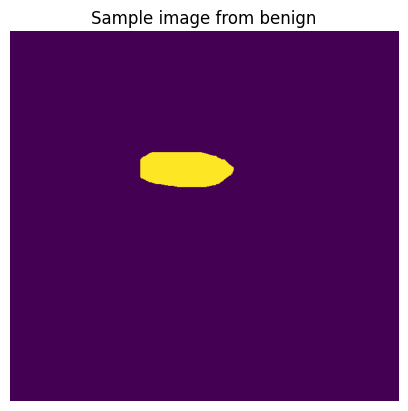

Category: malignant


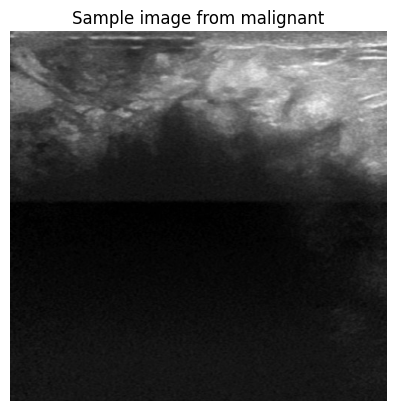

Category: normal


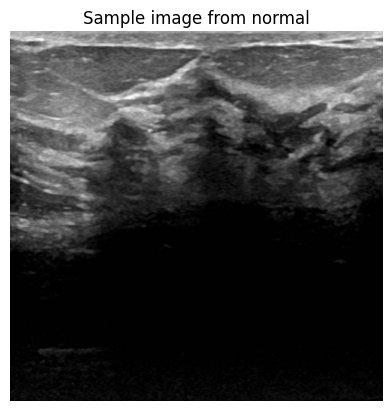

In [ ]:

# Define the path to the dataset
base_dir = '/content/breast_ultrasound_images/Dataset_BUSI_with_GT/'

# List all categories in the dataset
categories = ['benign', 'malignant', 'normal']

# Check the images and labels
for category in categories:
    print(f"Category: {category}")
    category_path = os.path.join(base_dir, category)

    # Get all image filenames in the category folder
    images = os.listdir(category_path)

    # Display the first image from the category folder
    if images:
        img_path = os.path.join(category_path, images[0])
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.title(f"Sample image from {category}")
        plt.axis('off')
        plt.show()

**Listing all categories of different dataset**

In [ ]:
# List all categories in the dataset
categories = ['benign', 'malignant', 'normal']

# Check the images and labels
for category in categories:
    print(f"Category: {category}")
    category_path = os.path.join(base_dir, category)

    # Get all image filenames in the category folder
    images = os.listdir(category_path)
    print(f"Number of images in {category}: {len(images)}\n")

Category: benign
Number of images in benign: 891

Category: malignant
Number of images in malignant: 421

Category: normal
Number of images in normal: 266



**Splitting**

In [ ]:

def split_data(base_dir, categories, train_size=0.8, val_size=0.1, test_size=0.1):
    # Ensure the sum of splits equals 1
    assert train_size + val_size + test_size == 1

    # Prepare dictionaries to hold the data splits and category counts
    splits = {'train': [], 'val': [], 'test': []}
    category_counts = {'train': {}, 'val': {}, 'test': {}}

    for category in categories:
        # Initialize category counts
        category_counts['train'][category] = 0
        category_counts['val'][category] = 0
        category_counts['test'][category] = 0

        category_path = os.path.join(base_dir, category)
        images = os.listdir(category_path)
        np.random.shuffle(images)  # Shuffle the images to ensure random splitting

        # Calculate split sizes
        n_total = len(images)
        n_train = int(n_total * train_size)
        n_val = int(n_total * val_size)

        # Assign data to splits
        train_images = images[:n_train]
        val_images = images[n_train:n_train + n_val]
        test_images = images[n_train + n_val:]

        # Store data in dictionaries and count
        splits['train'].extend([(os.path.join(category, img), category) for img in train_images])
        splits['val'].extend([(os.path.join(category, img), category) for img in val_images])
        splits['test'].extend([(os.path.join(category, img), category) for img in test_images])

        # Update counts
        category_counts['train'][category] += len(train_images)
        category_counts['val'][category] += len(val_images)
        category_counts['test'][category] += len(test_images)

    # Optionally shuffle the split data to mix categories
    for split in splits:
        np.random.shuffle(splits[split])

    return splits, category_counts


In [ ]:
# Get the data splits and category counts
data_splits, category_counts = split_data(base_dir, categories)

# Print out the number of images in each split for each category
for split, counts in category_counts.items():
    print(f"{split} split:")
    for category, count in counts.items():
        print(f"  {category}: {count} images")

train split:
  benign: 712 images
  malignant: 336 images
  normal: 212 images
val split:
  benign: 89 images
  malignant: 42 images
  normal: 26 images
test split:
  benign: 90 images
  malignant: 43 images
  normal: 28 images


In [ ]:


def create_split_folders(base_dir, splits, output_dir):
    """
    Creates train, val, and test directories and organizes images into respective folders.

    Parameters:
        base_dir (str): The base directory of the dataset.
        splits (dict): The dictionary containing the splits (train, val, test).
        output_dir (str): The directory where the split folders will be created.
    """
    for split in splits:
        split_dir = os.path.join(output_dir, split)
        os.makedirs(split_dir, exist_ok=True)  # Create split folder if it doesn't exist

        for image_path, label in splits[split]:
            # Create a subdirectory for the label (category) if it doesn't exist
            label_dir = os.path.join(split_dir, label)
            os.makedirs(label_dir, exist_ok=True)

            # Full source path of the image
            src_path = os.path.join(base_dir, image_path)
            # Full destination path of the image
            dest_path = os.path.join(label_dir, os.path.basename(image_path))

            # Copy image to the respective folder
            shutil.copy(src_path, dest_path)
            print(f"Copied {src_path} to {dest_path}")

# Base directory and output directory
base_dir = '/content/breast_ultrasound_images/Dataset_BUSI_with_GT'
output_dir = '/content/breast_ultrasound_images/Split_Dataset'

# Use the data_splits dictionary created earlier
create_split_folders(base_dir, data_splits, output_dir)


Copied /content/breast_ultrasound_images/Dataset_BUSI_with_GT/normal/normal (6)_mask.png to /content/breast_ultrasound_images/Split_Dataset/train/normal/normal (6)_mask.png
Copied /content/breast_ultrasound_images/Dataset_BUSI_with_GT/benign/benign (178).png to /content/breast_ultrasound_images/Split_Dataset/train/benign/benign (178).png
Copied /content/breast_ultrasound_images/Dataset_BUSI_with_GT/normal/normal (92).png to /content/breast_ultrasound_images/Split_Dataset/train/normal/normal (92).png
Copied /content/breast_ultrasound_images/Dataset_BUSI_with_GT/benign/benign (199)_mask.png to /content/breast_ultrasound_images/Split_Dataset/train/benign/benign (199)_mask.png
Copied /content/breast_ultrasound_images/Dataset_BUSI_with_GT/benign/benign (398).png to /content/breast_ultrasound_images/Split_Dataset/train/benign/benign (398).png
Copied /content/breast_ultrasound_images/Dataset_BUSI_with_GT/malignant/malignant (144).png to /content/breast_ultrasound_images/Split_Dataset/train/ma

**Model Building using VGG16**

In [ ]:

# Define the paths for the splits
split_base_dir = '/content/breast_ultrasound_images/Split_Dataset'

train_dir = os.path.join(split_base_dir, 'train')
val_dir = os.path.join(split_base_dir, 'val')
test_dir = os.path.join(split_base_dir, 'test')

# Set up data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,                # Normalize pixel values to [0, 1]
    rotation_range=40,             # Random rotation
    width_shift_range=0.2,         # Horizontal shift
    height_shift_range=0.2,        # Vertical shift
    shear_range=0.2,               # Shear transformation
    zoom_range=0.2,                # Random zoom
    horizontal_flip=True,          # Flip images horizontally
    fill_mode='nearest'            # Fill missing pixels with nearest values
)

# Validation and test sets only need rescaling (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
batch_size = 64
target_size = (150, 150)  # Resize images to 150x150 (adjust as needed)

# Training generator with augmentation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Validation generator (no augmentation)
validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Test generator (no augmentation, no shuffling)
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)



Found 1260 images belonging to 3 classes.
Found 157 images belonging to 3 classes.
Found 161 images belonging to 3 classes.


In [ ]:

# Load VGG16 model pre-trained on ImageNet data
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create custom layers for our own classifier
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)  # With L2 regularization
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(3, activation='softmax')(x)  # Assuming 3 classes

model= Model(inputs=base_model.input, outputs=x)

In [ ]:
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 512)                 │           2,0

 Total params: 14,982,979 (57.16 MB)

 Trainable params: 266,243 (1.02 MB)

 Non-trainable params: 14,716,736 (56.14 MB)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Fit the model using the train and validation data generators
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50
)


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.3961 - loss: 1.9716 - val_accuracy: 0.5547 - val_loss: 1.5343
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.4375 - loss: 1.7544 - val_accuracy: 0.6897 - val_loss: 1.4862
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 481ms/step - accuracy: 0.5527 - loss: 1.5729 - val_accuracy: 0.5625 - val_loss: 1.4578
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5625 - loss: 1.6059 - val_accuracy: 0.6207 - val_loss: 1.3982
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 470ms/step - accuracy: 0.6747 - loss: 1.3157 - val_accuracy: 0.6094 - val_loss: 1.3969
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6562 - loss: 1.3859 - val_accuracy: 0.6552 - val_loss: 1.3601
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 461ms/step - accuracy: 0.6585 - loss: 1.3281 - val_accuracy: 0.6641 - val_loss: 1.3455
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5469 - loss: 1.6350 - val_accuracy: 0.5862 

**Test Folder Accuracy**

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test accuracy: {test_acc*100:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step - accuracy: 0.8646 - loss: 0.7969
Test accuracy: 85.16%


**Learning Curve**

In [ ]:

def plot_learning_curves(history):
    # Get training and validation accuracy histories
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    # Get training and validation loss histories
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_accuracy) + 1)

    # Visualize accuracy history
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epoch_count, training_accuracy, 'r--')
    plt.plot(epoch_count, validation_accuracy, 'b-')
    plt.legend(['Training Accuracy', 'Validation Accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

    # Visualize loss history
    plt.subplot(1, 2, 2)
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, validation_loss, 'b-')
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    plt.tight_layout()
    plt.show()



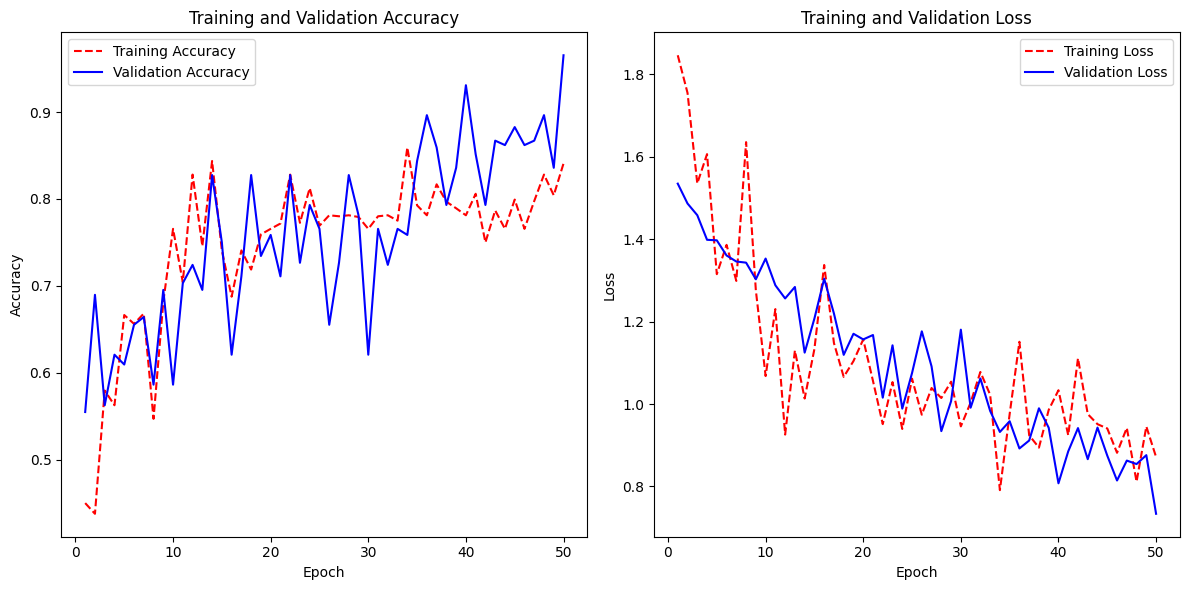

In [ ]:
plot_learning_curves(history)


**Testing along with Confidence**

In [ ]:
def test_model_on_test_set(model, test_generator):
    """
    Tests a trained model on a provided test data generator and outputs the predictions,
    true labels, and confidence levels.

    Args:
    model (tf.keras.Model): The trained model.
    test_generator (ImageDataGenerator.flow_from_directory): The test data generator.

    Returns:
    Prints the filename, true label, predicted label, and confidence of each prediction.
    """
    # Ensure the generator is not shuffling data to keep labels aligned with predictions
    test_generator.shuffle = False
    test_generator.reset()

    # Calculate the correct number of steps as an integer
    steps = int(np.ceil(test_generator.samples / test_generator.batch_size))

    # Get predictions
    predictions = model.predict(test_generator, steps=steps)
    predicted_classes = np.argmax(predictions, axis=1)
    confidences = np.max(predictions, axis=1)

    # Get the true class indices
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())

    # Iterate through files and print out the results
    for i in range(len(predictions)):
        filename = test_generator.filenames[i]
        true_label = class_labels[true_classes[i]]
        predicted_label = class_labels[predicted_classes[i]]
        confidence = confidences[i]
        print(f"File: {filename}")
        print(f"True Label: {true_label}")
        print(f"Predicted Label: {predicted_label} with confidence {confidence * 100:.2f}%\n")

# Example usage, ensure you pass the correctly set up test_generator
test_model_on_test_set(model, test_generator)


3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step
File: benign/benign (100)_mask_1.png
True Label: benign
Predicted Label: benign with confidence 97.24%

File: benign/benign (101).png
True Label: benign
Predicted Label: benign with confidence 82.05%

File: benign/benign (110)_mask.png
True Label: benign
Predicted Label: benign with confidence 99.57%

File: benign/benign (114).png
True Label: benign
Predicted Label: benign with confidence 34.58%

File: benign/benign (12).png
True Label: benign
Predicted Label: benign with confidence 55.97%

File: benign/benign (120).png
True Label: benign
Predicted Label: malignant with confidence 52.83%

File: benign/benign (137).png
True Label: benign
Predicted Label: benign with confidence 59.55%

File: benign/benign (153)_mask.png
True Label: benign
Predicted Label: benign with confidence 94.17%

File: benign/benign (169).png
True Label: benign
Predicted Label: benign with confidence 68.56%

File: benign/benign (172).png
True Label: benign
Predicted Label: benig

**Confusion Matrix**

In [ ]:

def get_predictions_and_labels(model, test_generator):
    """
    Returns predictions and true labels for the test set.

    Args:
    model (tf.keras.Model): The trained model.
    test_generator (ImageDataGenerator.flow_from_directory): The test data generator.

    Returns:
    numpy.array: predicted_classes, numpy.array: true_classes
    """
    test_generator.reset()
    steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
    predictions = model.predict(test_generator, steps=steps)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes
    return predicted_classes, true_classes


In [ ]:


# Assume model and test_generator are already defined and properly configured
predicted_classes, true_classes = get_predictions_and_labels(model, test_generator)

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


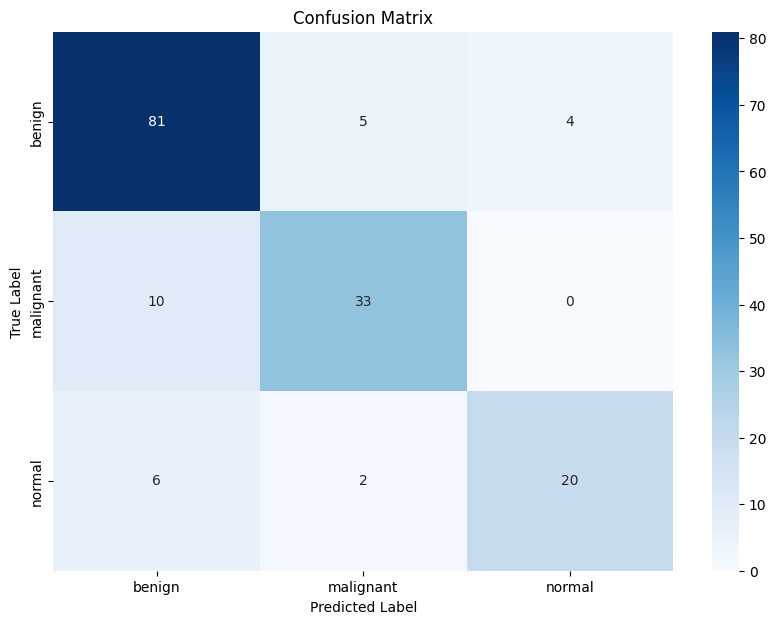

In [ ]:
def plot_confusion_matrix(cm, class_names):
    """
    Plots a confusion matrix using seaborn's heatmap.

    Args:
    cm (numpy.array): The confusion matrix to be plotted.
    class_names (list): List of class names for the axis labels.
    """
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Assuming class_labels is defined as list of class names
class_labels = list(test_generator.class_indices.keys())
plot_confusion_matrix(cm, class_labels)


**Evaluation Result**

In [ ]:
# Get predictions and true labels
predicted_classes, true_classes = get_predictions_and_labels(model, test_generator)

# Calculate metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='macro')  # 'macro' ignores label imbalance
recall = recall_score(true_classes, predicted_classes, average='macro')
f1 = f1_score(true_classes, predicted_classes, average='macro')

# Print the results
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 366ms/step
Accuracy: 83.23%
Precision: 0.83
Recall: 0.79
F1 Score: 0.81
